# Assignment 3: Class Activation Map
In this assignment we will use the [Class Activation Mapping Technique](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) to demonstrate that object specific spatial information is available in pre-trained image classification networks.

## Introduction:
The final output convolution layers of a trained image classification network contain detailed semantic information about the input image. These feature maps, although low resolution (e.g. 7 x 7) also contain spatial information about the location of the primary object in the image. In the class activation mapping technique we wish to extract this spatial information pertaining to the identified class and overlay this activation on the input image as shown in the figure below.

![](https://github.com/tonyscan6003/etivities/blob/main/cam_img.JPG?raw=true)

* Try to understand the algorithm and plan out the steps required before starting to code.
* The Resnet 50 model has been imported and outputs the last convolution layer and the logits (output of classifier)
* You can display your final results on a 4 x 4 plot.
 * Skeleton code is provided along with a function to unormalise the dataloader images for display.
 * The activation map using a heat map color scheme can be overlaid on the images using matplotlib "alpha" which sets the transparancy of the image e.g. `plt.imshow(class_act_map,cmap=plt.cm.jet,alpha=0.4)`























## HouseKeeping
  Import Packages, set batch size and Size of Images input to network.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import time
import os
import numpy as np
import glob
import random
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, models
from torchvision import utils
from torchvision.transforms import ToTensor, v2, Pad, Grayscale
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
!pip install torchinfo
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [3]:
# Global Variables
HW_trg =224

## Import Dataset

 For this notebook we will use the pytorch [ImageNett dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html) which contains a sub-set of the ImageNet test dataset with only 10 examples per class. This will be sufficient to demonstrate the Class Activation Mapping algorithm.

The transform is setup without data augmentation and with the required normalisation for the ResNet50 model.

In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
imagenet_data = datasets.Imagenette('/root/INET',download=True,transform=transform)
data_loader = torch.utils.data.DataLoader(imagenet_data,
                                          batch_size=1,
                                          shuffle=True)

100%|██████████| 1.56G/1.56G [00:40<00:00, 38.3MB/s]


Plot a test image from the dataset. The image must be unnormalised and output in the correct form [H,W,C] for display by plt.imshow using `<unnormalise image function>`. (You can re-use this function later to unnormalise images that you will overlay the class activation maps onto.)

In [5]:

imagenette_dict={0:'Tench Fish',217:'English Springer',482:'Casette Player',
                491:'Chain Saw',497:'Church',566:'French Horn',
                 569:'Grabage Truck',571:'Gas Pump',574:'Golfball',
                 662:'Modem', 701:'Parachute',864:'Tow Truck', 867:'Trailer Truck'}
mean = [0.485, 0.456, 0.406]  # Example mean used for normalization
std = [0.229, 0.224, 0.225]   # Example std used for normalization

def unnormalize_image(image, mean, std):
    """
    Unnormalize a PyTorch image tensor.

    Args:
        image (torch.Tensor): The normalized image tensor of shape [C, H, W].
        mean (list or tuple): The mean used for normalization.
        std (list or tuple): The standard deviation used for normalization.

    Returns:
        torch.Tensor: The unnormalized image tensor.
    """
    # Remove the batch dimension
    image = image.squeeze(0)

    # Check if the image is in the shape [C, H, W]
    if image.dim() == 3:
        # Unnormalize the image
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)
    else:
        raise ValueError("Expected image tensor of shape [C, H, W]")

    # Convert from [C, x, y] to [x, y, C]
    image = image.permute(1, 2, 0)

    return image

torch.Size([1, 3, 224, 224])


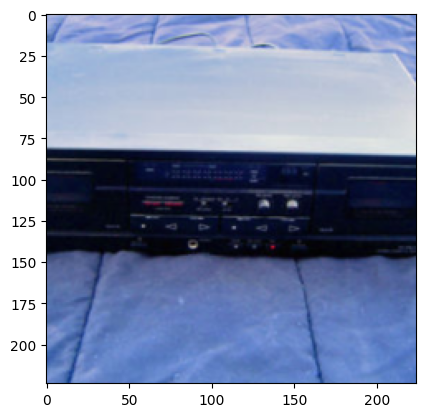

In [6]:
# Verity Dataloader & Image
dataiter = iter(data_loader)
z = next(dataiter)
print(np.shape(z[0]))

img=unnormalize_image(z[0],mean,std)
plt.imshow(img)




# Import Model

This assignment can be completed with CPU runtime as only inference from the model is required. The ResNet50 model is imported for this Assignment. As detailed in the paper a global average pooling layer conected to the classifier layer is required to work. The Resnet50 model satisfies this requirement (without needing modification & retraining)

In [7]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


ResNet50 Model is loaded & modified with [create_feature_extraction](https://pytorch.org/vision/stable/feature_extraction.html) to allow output of both logits and feature maps

In [8]:
# Load Model with weights
resnet50 = models.resnet50(pretrained=True)

# Obtain list of graph nodes
train_nodes, eval_nodes = get_graph_node_names(resnet50)
#print(train_nodes)

# Define Dictionary of output nodes
return_nodes={'layer4.2.conv3':'op_features','fc':'op_logits'}

# Create new model using the return nodes
model=create_feature_extractor(resnet50, return_nodes=return_nodes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 144MB/s]


In [9]:
# Plot Model Summary
from torchinfo import summary
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Module: 1-5                            --                        --
│    └─Module: 2-1                       --                        --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

Test Passing data through model & verify outputs.

In [10]:
#pass data through model
out=model(z[0])
print([(k, v.shape) for k, v in out.items()])


[('op_features', torch.Size([1, 2048, 7, 7])), ('op_logits', torch.Size([1, 1000]))]


Obtain weights of classifier layer of model from state dictionary

In [11]:
sd = model.state_dict()
print(sd.keys())
print(np.shape((sd['fc.weight'])))

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.we

# Class Activion Mapping
You can implement the class activation mapping algorithm in the code cell below.



z:  [tensor([[[[-1.8953, -1.9124, -1.9124,  ...,  0.4337,  0.3823,  0.3309],
          [-1.9124, -1.9124, -1.9295,  ...,  0.3652,  0.1939, -0.0972],
          [-1.9295, -1.9467, -1.9467,  ...,  0.3309, -0.0458, -0.5938],
          ...,
          [ 0.0569,  0.1083,  0.2111,  ..., -1.7240, -1.7754, -1.7925],
          [ 0.0741,  0.1426,  0.2282,  ..., -1.7925, -1.7583, -1.7412],
          [ 0.1597,  0.2453,  0.3652,  ..., -1.7412, -1.7925, -1.7925]],

         [[-1.9657, -1.9832, -2.0007,  ...,  0.8880,  0.8179,  0.7829],
          [-2.0007, -2.0007, -2.0182,  ...,  0.8179,  0.6078,  0.3102],
          [-2.0182, -2.0007, -2.0007,  ...,  0.7829,  0.3803, -0.1800],
          ...,
          [-1.3704, -1.3179, -1.3004,  ..., -1.8957, -1.9482, -1.9657],
          [-1.3704, -1.3529, -1.2654,  ..., -1.9832, -1.9307, -1.8957],
          [-1.3529, -1.3004, -1.1604,  ..., -1.8957, -1.9482, -1.9307]],

         [[-1.8044, -1.8044, -1.8044,  ...,  1.5245,  1.5594,  1.4025],
          [-1.8044, -1.80

<ipython-input-17-a84a01f1f477>:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = get_value(imagenette_dict,int(curr_class.numpy()))


curr_class:  tensor([6])
6
z:  [tensor([[[[0.6221, 0.6049, 0.6049,  ..., 0.9132, 0.9132, 0.9132],
          [0.6221, 0.6221, 0.6221,  ..., 0.9132, 0.9132, 0.9303],
          [0.6221, 0.6392, 0.6563,  ..., 0.9132, 0.9303, 0.9303],
          ...,
          [0.7591, 0.7762, 0.7762,  ..., 1.0159, 1.0159, 1.0331],
          [0.7762, 0.7762, 0.7762,  ..., 1.0331, 1.0331, 1.0331],
          [0.7591, 0.7933, 0.7933,  ..., 1.0159, 1.0159, 1.0502]],

         [[0.9930, 0.9755, 0.9755,  ..., 1.2906, 1.2731, 1.2731],
          [0.9930, 0.9930, 0.9930,  ..., 1.3081, 1.2906, 1.2906],
          [0.9930, 1.0105, 1.0280,  ..., 1.3081, 1.3256, 1.2906],
          ...,
          [1.1331, 1.1506, 1.1506,  ..., 1.3782, 1.3782, 1.3957],
          [1.1506, 1.1506, 1.1506,  ..., 1.3957, 1.3957, 1.3957],
          [1.1331, 1.1681, 1.1681,  ..., 1.3782, 1.3782, 1.4132]],

         [[1.5071, 1.4897, 1.4897,  ..., 1.7511, 1.7337, 1.7337],
          [1.5071, 1.5071, 1.5071,  ..., 1.7511, 1.7511, 1.7511],
          

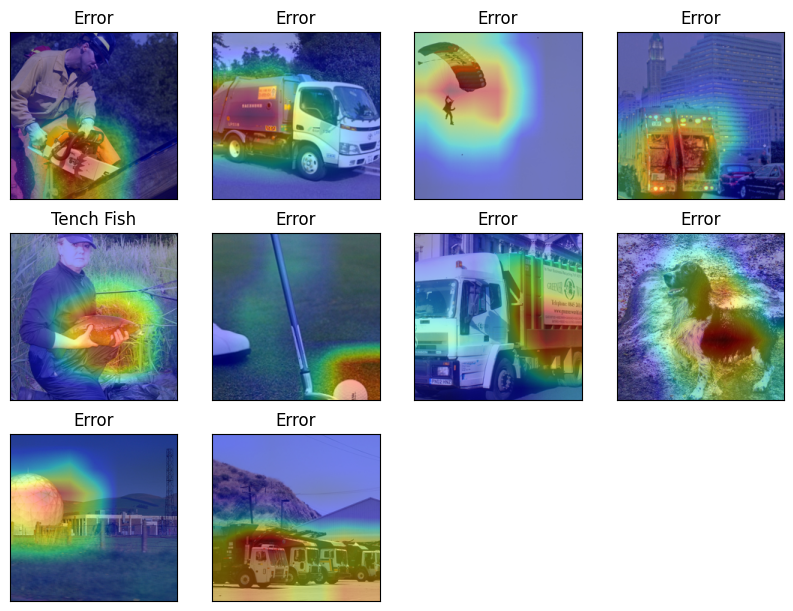

In [17]:

import matplotlib.pyplot as plt
import numpy as np

# Initialize Figure
fig = plt.figure(figsize=(10,10), frameon=False)


# Iterate over the dataiter to produce a few examples

# Ensure model is eval mode to disable batch normalisation during inference.
model.eval()
for i in range(10):

    # Forward pass through model
    z = next(dataiter)
    print("z: ", z)
    img_input = z[0].to(device)
    curr_class = z[1]
    out = model(img_input)
    feature_maps = out['op_features']        # shape: [1, 2048, 7, 7]
    logits = out['op_logits']                # shape: [1, 1000]

    # Get the class index with highest logit
    class_idx = torch.argmax(logits, dim=1)

    # Get the weights of the fully connected layer
    fc_weights = model.state_dict()['fc.weight']   # shape: [1000, 2048]

    # Extract weights for the predicted class
    class_weights = fc_weights[class_idx].squeeze()  # shape: [2048]

    # Compute class activation map (CAM)
    cam = torch.zeros(feature_maps.shape[2:], dtype=torch.float32).to(device)
    for j in range(feature_maps.shape[1]):
        cam += class_weights[j] * feature_maps[0, j, :, :]

    # Normalize CAM
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Resize CAM to match input image size
    act_map_us = torch.nn.functional.interpolate(cam.unsqueeze(0).unsqueeze(0),
                                                 size=(224, 224),
                                                 mode='bilinear',
                                                 align_corners=False).squeeze()
    # N. Plotting
    img = img_input
    def get_value(dictionary, key):
        try:
          print(key)
          return dictionary[key]
        except KeyError:
           return "Error"
    print("curr_class: ", curr_class)
    label = get_value(imagenette_dict,int(curr_class.numpy()))

    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.title.set_text(label)
    img=unnormalize_image(img,mean,std)
    ax.imshow(img)
    plt.imshow(img)
    plt.imshow(act_map_us.detach().numpy(), cmap=plt.cm.jet, alpha=0.4)

plt.show()

z:  [tensor([[[[-1.0562, -1.0733, -1.0904,  ..., -1.6384, -1.6213, -1.5870],
          [-1.1247, -1.1932, -1.2617,  ..., -1.6042, -1.5699, -1.5528],
          [-1.2617, -1.2959, -1.3473,  ..., -1.6213, -1.6042, -1.5870],
          ...,
          [-0.6794, -0.5253, -0.2684,  ..., -1.2445, -1.1932, -1.0562],
          [-0.7479, -0.5253, -0.1486,  ..., -1.1932, -1.1075, -0.9877],
          [-0.7308, -0.4397, -0.0116,  ..., -1.1418, -1.0904, -1.0219]],

         [[-0.7752, -0.7752, -0.8277,  ..., -1.4055, -1.4230, -1.4055],
          [-0.8978, -0.9153, -0.9503,  ..., -1.4405, -1.4405, -1.4405],
          [-1.0203, -1.0378, -1.0553,  ..., -1.4755, -1.4580, -1.4405],
          ...,
          [-0.3901, -0.1975,  0.1352,  ..., -1.0728, -1.0378, -0.9503],
          [-0.4426, -0.2150,  0.2052,  ..., -1.0203, -0.9678, -0.8627],
          [-0.3901, -0.1275,  0.3277,  ..., -1.0028, -0.9328, -0.8452]],

         [[-0.8284, -0.8284, -0.8633,  ..., -1.1944, -1.1944, -1.1596],
          [-0.9504, -0.96

<ipython-input-18-64ce1e656647>:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = get_value(imagenette_dict,int(curr_class.numpy()))


curr_class:  tensor([2])
2
z:  [tensor([[[[-0.3027, -0.3027,  0.1083,  ..., -0.2856, -0.2856, -0.2856],
          [-0.2684, -0.2684, -0.1999,  ..., -0.2856, -0.2856, -0.2856],
          [-0.2171, -0.3027, -0.2684,  ..., -0.2856, -0.2856, -0.2856],
          ...,
          [-0.2856, -0.2856, -0.2856,  ..., -0.2856, -0.2856, -0.2856],
          [-0.2856, -0.2856, -0.2856,  ..., -0.2856, -0.2856, -0.2856],
          [-0.2856, -0.2856, -0.2856,  ..., -0.2856, -0.2856, -0.2856]],

         [[ 1.5182,  1.5007,  1.4482,  ...,  1.5007,  1.5007,  1.5007],
          [ 1.4832,  1.5007,  1.4657,  ...,  1.5007,  1.5007,  1.5007],
          [ 1.5182,  1.4832,  1.4832,  ...,  1.5007,  1.5007,  1.5007],
          ...,
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5007,  1.5007],
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5007,  1.5007],
          [ 1.5007,  1.5007,  1.5007,  ...,  1.5007,  1.5007,  1.5007]],

         [[ 2.5703,  2.6051,  2.4134,  ...,  2.6400,  2.6400,  2.6400]

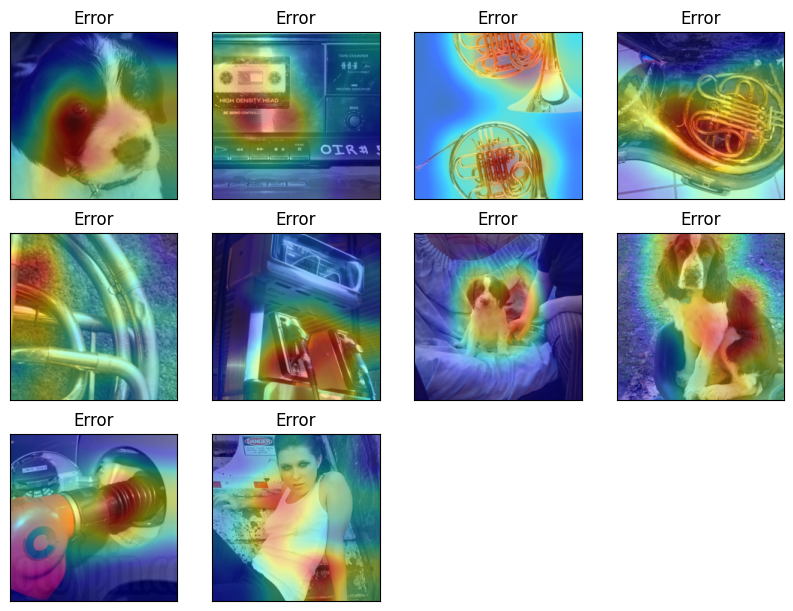

In [18]:

import matplotlib.pyplot as plt
import numpy as np

# Initialize Figure
fig = plt.figure(figsize=(10,10), frameon=False)


# Iterate over the dataiter to produce a few examples

# Ensure model is eval mode to disable batch normalisation during inference.
model.eval()
for i in range(10):

    # Forward pass through model
    z = next(dataiter)
    print("z: ", z)
    img_input = z[0].to(device)
    curr_class = z[1]
    out = model(img_input)
    feature_maps = out['op_features']        # shape: [1, 2048, 7, 7]
    logits = out['op_logits']                # shape: [1, 1000]

    # Get the class index with highest logit
    class_idx = torch.argmax(logits, dim=1)

    # Get the weights of the fully connected layer
    fc_weights = model.state_dict()['fc.weight']   # shape: [1000, 2048]

    # Extract weights for the predicted class
    class_weights = fc_weights[class_idx].squeeze()  # shape: [2048]

    # Compute class activation map (CAM)
    cam = torch.zeros(feature_maps.shape[2:], dtype=torch.float32).to(device)
    for j in range(feature_maps.shape[1]):
        cam += class_weights[j] * feature_maps[0, j, :, :]

    # Normalize CAM
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Resize CAM to match input image size
    act_map_us = torch.nn.functional.interpolate(cam.unsqueeze(0).unsqueeze(0),
                                                 size=(224, 224),
                                                 mode='bicubic',
                                                 align_corners=False).squeeze()
    # N. Plotting
    img = img_input
    def get_value(dictionary, key):
        try:
          print(key)
          return dictionary[key]
        except KeyError:
           return "Error"
    print("curr_class: ", curr_class)
    label = get_value(imagenette_dict,int(curr_class.numpy()))

    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.title.set_text(label)
    img=unnormalize_image(img,mean,std)
    ax.imshow(img)
    plt.imshow(img)
    plt.imshow(act_map_us.detach().numpy(), cmap=plt.cm.jet, alpha=0.4)

plt.show()

z:  [tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2318, 2.2489,  ..., 2.2318, 2.2489, 2.2318],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2318, 2.2489, 2.2318,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2318,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4111, 2.4111, 2.4111,  ..., 2.4111, 2.3936, 2.4111],
          [2.4286, 2.4286, 2.4286,  ..., 2.4111, 2.3936, 2.4111],
          [2.4286, 2.4286, 2.4286,  ..., 2.4111, 2.3936, 2.4111],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4111, 2.4286, 2.4111,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4111,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.5877, 2.5877, 2.5877,  ..., 2.5877, 2.5877, 2.5877],
          [2.5877, 2.5877, 2.5877,  ..., 2.5703, 2.5703, 2.5703],
          [2.6051, 2.6051, 2.6051,  .

<ipython-input-19-057cc18d5cba>:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = get_value(imagenette_dict,int(curr_class.numpy()))


curr_class:  tensor([1])
1
z:  [tensor([[[[-1.0390, -1.0390, -1.0562,  ..., -1.6898, -1.6384, -1.5870],
          [-1.0733, -1.0562, -1.0562,  ..., -1.7240, -1.6555, -1.6042],
          [-1.1075, -1.0904, -1.1075,  ..., -1.7240, -1.6555, -1.5870],
          ...,
          [-0.6623, -0.6623, -0.4739,  ..., -1.0390, -1.5699, -0.9192],
          [-0.4397, -0.0801,  0.0398,  ..., -1.0562, -1.4672, -0.6623],
          [-0.1143, -0.1657, -0.1143,  ..., -0.7993, -0.7993, -0.5082]],

         [[-0.8803, -0.8803, -0.8627,  ..., -1.5630, -1.5105, -1.4405],
          [-0.8978, -0.8627, -0.8803,  ..., -1.5630, -1.4930, -1.4405],
          [-0.9328, -0.8978, -0.9153,  ..., -1.5105, -1.4230, -1.4055],
          ...,
          [-0.3200, -0.3025, -0.1800,  ..., -0.3901, -1.0203, -0.4426],
          [-0.3725,  0.0651,  0.1702,  ..., -0.3725, -0.7577, -0.1625],
          [ 0.1352,  0.1702,  0.2577,  ..., -0.2500, -0.1800,  0.0651]],

         [[-1.0201, -1.0201, -1.0201,  ..., -1.5953, -1.5779, -1.5779]

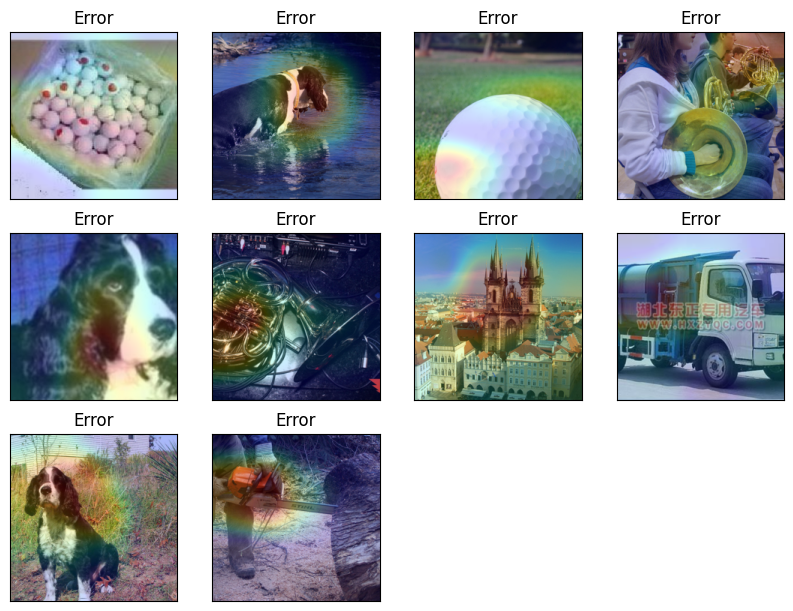

In [19]:

import matplotlib.pyplot as plt
import numpy as np

# Initialize Figure
fig = plt.figure(figsize=(10,10), frameon=False)


# Iterate over the dataiter to produce a few examples

# Ensure model is eval mode to disable batch normalisation during inference.
model.eval()
for i in range(10):

    # Forward pass through model
    z = next(dataiter)
    print("z: ", z)
    img_input = z[0].to(device)
    curr_class = z[1]
    out = model(img_input)
    feature_maps = out['op_features']        # shape: [1, 2048, 7, 7]
    logits = out['op_logits']                # shape: [1, 1000]

    # Get the class index with highest logit
    class_idx = torch.argmax(logits, dim=1)

    # Get the weights of the fully connected layer
    fc_weights = model.state_dict()['fc.weight']   # shape: [1000, 2048]

    # Extract weights for the predicted class
    class_weights = fc_weights[class_idx].squeeze()  # shape: [2048]

    # Compute class activation map (CAM)
    cam = torch.zeros(feature_maps.shape[2:], dtype=torch.float32).to(device)
    for j in range(feature_maps.shape[1]):
        cam += class_weights[j] * feature_maps[0, j, :, :]

    # Normalize CAM
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Resize CAM to match input image size
    act_map_us = torch.nn.functional.interpolate(cam.unsqueeze(0).unsqueeze(0),
                                                 size=(224, 224),
                                                 mode='bicubic',
                                                 align_corners=False).squeeze()
    # N. Plotting
    img = img_input
    def get_value(dictionary, key):
        try:
          print(key)
          return dictionary[key]
        except KeyError:
           return "Error"
    print("curr_class: ", curr_class)
    label = get_value(imagenette_dict,int(curr_class.numpy()))

    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.title.set_text(label)
    img=unnormalize_image(img,mean,std)
    ax.imshow(img)
    plt.imshow(img)
    plt.imshow(act_map_us.detach().numpy(), cmap=plt.cm.jet, alpha=0.2)

plt.show()

z:  [tensor([[[[-0.3883, -0.3712, -0.3712,  ..., -0.5253, -0.5596, -0.5596],
          [-0.3712, -0.3712, -0.3712,  ..., -0.5424, -0.5767, -0.5767],
          [-0.3883, -0.3541, -0.3541,  ..., -0.5253, -0.5596, -0.5596],
          ...,
          [-0.0972, -0.0801, -0.0629,  ..., -0.2684, -0.2856, -0.2513],
          [-0.0972, -0.0629, -0.0801,  ..., -0.2513, -0.2684, -0.2342],
          [-0.1143, -0.0801, -0.0972,  ..., -0.2856, -0.2684, -0.2513]],

         [[ 0.8704,  0.8529,  0.8529,  ...,  0.5553,  0.5728,  0.5553],
          [ 0.8529,  0.8704,  0.8704,  ...,  0.5553,  0.5728,  0.5903],
          [ 0.8529,  0.8529,  0.8529,  ...,  0.5378,  0.5553,  0.5728],
          ...,
          [ 1.2206,  1.1856,  1.2031,  ...,  0.9930,  0.9930,  0.9755],
          [ 1.2206,  1.2031,  1.2206,  ...,  0.9580,  0.9930,  0.9755],
          [ 1.2206,  1.2031,  1.2206,  ...,  0.9930,  0.9930,  0.9930]],

         [[ 2.3088,  2.3088,  2.3263,  ...,  2.0997,  2.1346,  2.1520],
          [ 2.2914,  2.29

<ipython-input-20-31792722301c>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = get_value(imagenette_dict,int(curr_class.numpy()))


curr_class:  tensor([5])
5
z:  [tensor([[[[-0.7479, -0.7479, -0.7137,  ..., -0.6965, -0.7479, -0.7479],
          [-0.7308, -0.7822, -0.7822,  ..., -0.7137, -0.7479, -0.7822],
          [-0.7822, -0.7822, -0.7822,  ..., -0.7308, -0.7650, -0.7650],
          ...,
          [-0.6965, -0.6965, -0.6794,  ..., -0.6965, -0.7308, -0.7137],
          [-0.6623, -0.6623, -0.7137,  ..., -0.6794, -0.7650, -0.7650],
          [-0.6965, -0.6965, -0.7479,  ..., -0.6965, -0.7137, -0.7650]],

         [[ 0.3277,  0.3452,  0.3102,  ...,  0.3102,  0.3452,  0.3277],
          [ 0.2927,  0.3102,  0.3102,  ...,  0.2927,  0.3452,  0.3277],
          [ 0.3277,  0.3102,  0.2927,  ...,  0.2927,  0.3452,  0.3452],
          ...,
          [ 0.3978,  0.3803,  0.3452,  ...,  0.3627,  0.3978,  0.3803],
          [ 0.3452,  0.3803,  0.3803,  ...,  0.3627,  0.3978,  0.3803],
          [ 0.3452,  0.3627,  0.3978,  ...,  0.3803,  0.3803,  0.3978]],

         [[ 1.4374,  1.4374,  1.4025,  ...,  1.4374,  1.4025,  1.4200]

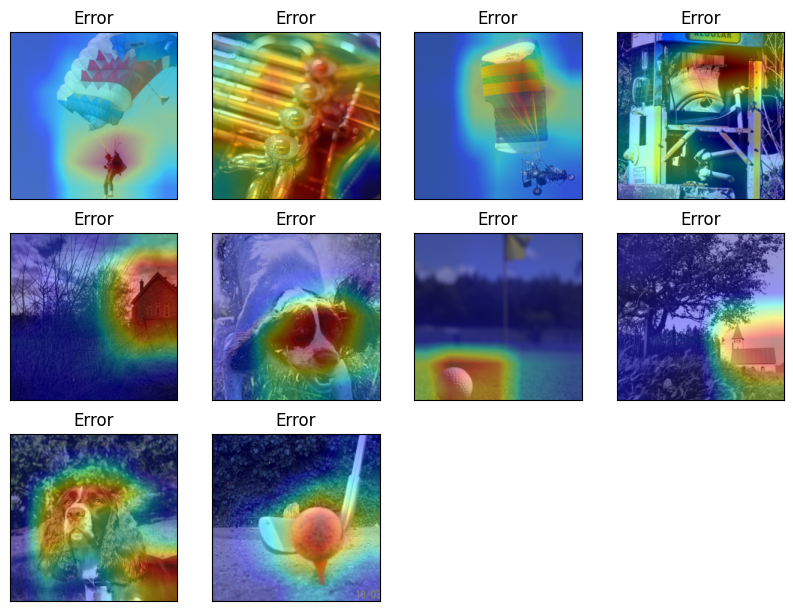

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize Figure
fig = plt.figure(figsize=(10,10), frameon=False)

# Iterate over the dataiter to produce a few examples
# Ensure model is eval mode to disable batch normalisation during inference.
model.eval()
for i in range(10):

    # Forward pass through model
    z = next(dataiter)
    print("z: ", z)
    img_input = z[0].to(device)
    curr_class = z[1]
    out = model(img_input)
    feature_maps = out['op_features']        # shape: [1, 2048, 7, 7]
    logits = out['op_logits']                # shape: [1, 1000]

    reduced_features = feature_maps.clone()
    reduced_features[:, reduced_features.shape[1]//2:, :, :] = 0

    # Get the class index with highest logit
    class_idx = torch.argmax(logits, dim=1)

    # Get the weights of the fully connected layer
    fc_weights = model.state_dict()['fc.weight']   # shape: [1000, 2048]

    # Extract weights for the predicted class
    class_weights = fc_weights[class_idx].squeeze()  # shape: [2048]

    # Compute class activation map (CAM) using reduced features
    cam = torch.zeros(reduced_features.shape[2:], dtype=torch.float32).to(device)
    for j in range(reduced_features.shape[1]):
        cam += class_weights[j] * reduced_features[0, j, :, :]

    # Normalize CAM
    cam = cam - cam.min()
    cam = cam / cam.max()

    # Resize CAM to match input image size
    act_map_us = torch.nn.functional.interpolate(cam.unsqueeze(0).unsqueeze(0),
                                                 size=(224, 224),
                                                 mode='bilinear',
                                                 align_corners=False).squeeze()
    # N. Plotting
    img = img_input
    def get_value(dictionary, key):
        try:
          print(key)
          return dictionary[key]
        except KeyError:
           return "Error"
    print("curr_class: ", curr_class)
    label = get_value(imagenette_dict,int(curr_class.numpy()))

    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.title.set_text(label)
    img=unnormalize_image(img,mean,std)
    ax.imshow(img)
    plt.imshow(img)
    plt.imshow(act_map_us.detach().numpy(), cmap=plt.cm.jet, alpha=0.4)

plt.show()

# You may Leave a note here explaining your approach/results for the e-moderator.

Please clearly identify any code blocks you have used, suggestions your have tried or ideas obtained from other students. This information may also be posted as a final reflection post in the forum.

Following are the suggestions and my reflections of two simple and important ideas. The code blocks of what I have tried are present above.

NOTE: Some of the labels of images is named as "Error" since it is inevitable to keep track of the entire labelling in a map. Also, I have printed some tensors before plotting the activation maps. You may have to scroll in the output section to view the plot.

Peer 1: Use 'bicubic' instead of 'bilinear' for interpolation:

From this suggestion, I learned how different interpolation methods impact the quality of the class activation maps (CAMs). While I initially used 'bilinear' interpolation to upscale the CAMs to input image size, trying 'bicubic' helped me understand that it produces smoother and more refined visualizations by considering more surrounding pixel values. This was especially noticeable around object edges where detail preservation matters. It taught me the importance of choosing the right resampling technique when visualizing model attention, and how it can influence the interpretability of results. This connects with resampling concepts explained in Szeliski’s book, particularly where image transformations are discussed.

Peer 2: Visualize CAMs from Earlier Layers:

This suggestion helped me understand the role of feature hierarchies in CNNs. By experimenting with activation maps from earlier layers (e.g., layer3 instead of layer4), I saw how the network first detects basic visual patterns like edges and textures before gradually abstracting those into higher-level object features. Visualizing CAMs at different depths gave me a clearer picture of how the model’s understanding evolves through the network. This helped me appreciate how convolutional layers build up semantic meaning layer by layer, which is foundational to interpreting CNN behavior. The idea directly relates to the concept of hierarchical feature extraction in deep learning as described in Szeliski’s chapters on image representations and recognition.